In [1]:
from utils import get_som_labeled_img, check_ocr_box, get_caption_model_processor, get_yolo_model
import torch
from ultralytics import YOLO
from PIL import Image
device = 'cuda'
model_path='weights/icon_detect_v1_5/model_v1_5.pt'

som_model = get_yolo_model(model_path)

som_model.to(device)
print('model to {}'.format(device))

model to cuda


In [2]:
# two choices for caption model: fine-tuned blip2 or florence2
import importlib
import utils
importlib.reload(utils)
from utils import get_som_labeled_img, check_ocr_box, get_caption_model_processor, get_yolo_model
# caption_model_processor = get_caption_model_processor(model_name="blip2", model_name_or_path="weights/icon_caption_blip2", device=device)
caption_model_processor = get_caption_model_processor(model_name="florence2", model_name_or_path="weights/icon_caption_florence", device=device)



Florence2LanguageForConditionalGeneration has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.


In [3]:
som_model.device, type(som_model) 

(device(type='cuda', index=0), ultralytics.models.yolo.model.YOLO)

In [4]:
# reload utils
import importlib
import utils
importlib.reload(utils)
from utils import get_som_labeled_img, check_ocr_box, get_caption_model_processor, get_yolo_model

image_path = 'imgs/google_page.png'
image_path = 'imgs/windows_home.png'
# image_path = 'imgs/windows_multitab.png'
# image_path = 'imgs/omni3.jpg'
# image_path = 'imgs/ios.png'
image_path = 'imgs/word.png'
# image_path = 'imgs/excel2.png'

image = Image.open(image_path)
image_rgb = image.convert('RGB')
print('image size:', image.size)

box_overlay_ratio = max(image.size) / 3200
draw_bbox_config = {
    'text_scale': 0.8 * box_overlay_ratio,
    'text_thickness': max(int(2 * box_overlay_ratio), 1),
    'text_padding': max(int(3 * box_overlay_ratio), 1),
    'thickness': max(int(3 * box_overlay_ratio), 1),
}
BOX_TRESHOLD = 0.05

import time
start = time.time()
ocr_bbox_rslt, is_goal_filtered = check_ocr_box(image_path, display_img = False, output_bb_format='xyxy', goal_filtering=None, easyocr_args={'paragraph': False, 'text_threshold':0.8}, use_paddleocr=True)
text, ocr_bbox = ocr_bbox_rslt
cur_time_ocr = time.time() 

dino_labled_img, label_coordinates, parsed_content_list = get_som_labeled_img(image_path, som_model, BOX_TRESHOLD = BOX_TRESHOLD, output_coord_in_ratio=True, ocr_bbox=ocr_bbox,draw_bbox_config=draw_bbox_config, caption_model_processor=caption_model_processor, ocr_text=text,use_local_semantics=True, iou_threshold=0.7, scale_img=False, batch_size=128)
cur_time_caption = time.time() 


image size: (1919, 1079)

image 1/1 /home/yadonglu/OmniParser/imgs/word.png: 736x1280 115 icons, 67.0ms
Speed: 7.0ms preprocess, 67.0ms inference, 423.3ms postprocess per image at shape (1, 3, 736, 1280)


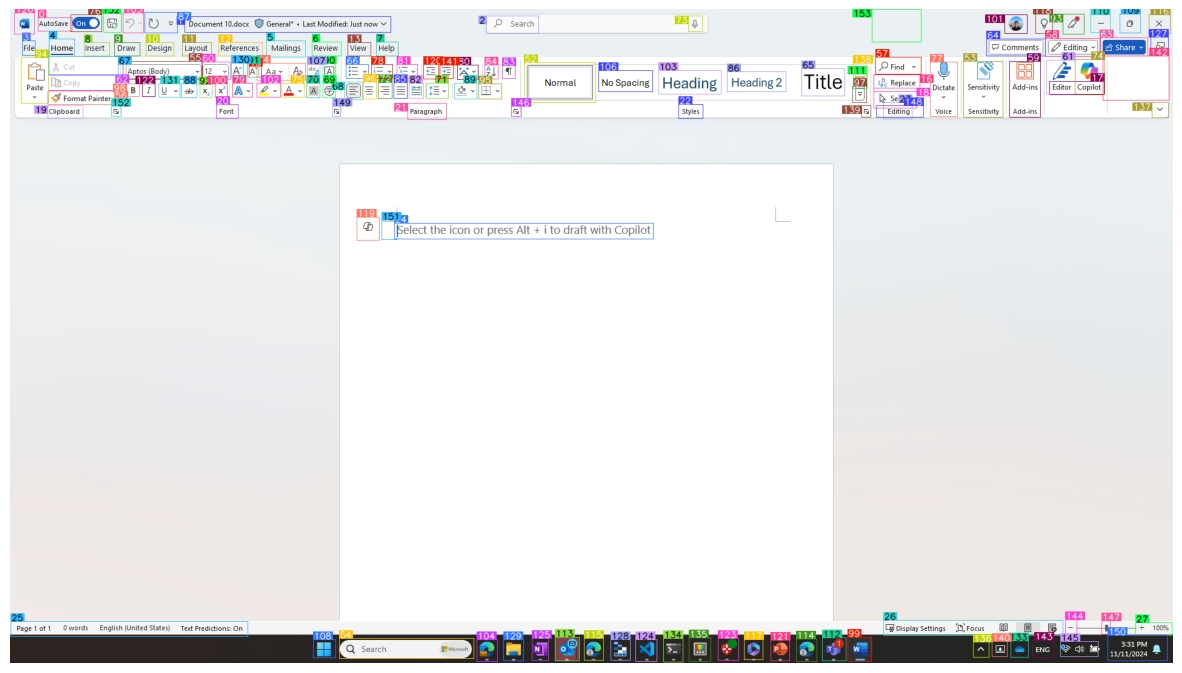

In [5]:
# plot dino_labled_img it is in base64
import base64
import matplotlib.pyplot as plt
import io
plt.figure(figsize=(15,15))

image = Image.open(io.BytesIO(base64.b64decode(dino_labled_img)))
plt.axis('off')

plt.imshow(image)
# print(len(parsed_content_list))


In [25]:
import pandas as pd
df = pd.DataFrame(parsed_content_list)
df['ID'] = range(len(df))

df

,type,bbox,interactivity,content,ID
0,text,"[0.1500781625509262, 0.011121409013867378, 0.3...",False,Document 10.docx General* Last Modified: Jus...,0
1,text,"[0.010943199507892132, 0.048192769289016724, 0...",False,File,1
2,text,"[0.03335070237517357, 0.045412417501211166, 0....",False,Home,2
3,text,"[0.22094841301441193, 0.048192769289016724, 0....",False,Mailings,3
4,text,"[0.2595101594924927, 0.05004633963108063, 0.28...",False,Review,4
...,...,...,...,...,...
136,icon,"[0.7451589703559875, 0.14763562381267548, 0.78...",True,Editing.,136
137,icon,"[0.27768608927726746, 0.1485075205564499, 0.28...",True,Redo,137
138,icon,"[0.31950756907463074, 0.3229200839996338, 0.33...",True,minimizing a window.,138
139,icon,"[0.08737719058990479, 0.148496612906456, 0.095...",True,Redo,139


In [6]:
parsed_content_list

[{'type': 'text',
  'bbox': [0.023970818147063255,
   0.012974976561963558,
   0.05315268412232399,
   0.033364225178956985],
  'interactivity': False,
  'content': 'AutoSave'},
 {'type': 'text',
  'bbox': [0.1500781625509262,
   0.011121409013867378,
   0.3272537887096405,
   0.03521779552102089],
  'interactivity': False,
  'content': 'Document 10.docx  General*  Last Modified: Just now '},
 {'type': 'text',
  'bbox': [0.4095883369445801,
   0.011121409013867378,
   0.4544033408164978,
   0.037071362137794495],
  'interactivity': False,
  'content': 'O Search'},
 {'type': 'text',
  'bbox': [0.010943199507892132,
   0.048192769289016724,
   0.021365294232964516,
   0.07043559104204178],
  'interactivity': False,
  'content': 'File'},
 {'type': 'text',
  'bbox': [0.03335070237517357,
   0.045412417501211166,
   0.05523710325360298,
   0.07228915393352509],
  'interactivity': False,
  'content': 'Home'},
 {'type': 'text',
  'bbox': [0.22094841301441193,
   0.048192769289016724,
   0.254